In [17]:
import astropy.units as u
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask
import scipy
import astropy.units as u
import warnings

from dask.distributed import Client
from nested_pandas.utils import count_nested
from dask.distributed import print as dask_print
from lsdb.core.search.pixel_search import PixelSearch
from lsdb.core.search.order_search import OrderSearch
from lsdb.core.search import ConeSearch
from io import StringIO
from nested_pandas import NestedDtype
from pathlib import Path

In [18]:
drp_release = "w_2025_11"
hats_dir = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats")
hats_path = hats_dir / drp_release
output_path = Path(
    "/sdf/data/rubin/shared/lsdb_commissioning/science_projects/06_uncertainty/object_whiten"
)

There's not that much going on here! We did all the work on all the objects and lightcurves in the previous notebook, so this is just aggregating the histograms over all lightcurves.

In [19]:
## Useful constants

bands = ["u", "g", "r", "i", "z", "y"]

partial_meta = {"mag_bin":    "float64",
"sum":        "float64",
"sum_sq":     "float64",
"count":      "float64"}


fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45),  # Fornax Dwarf Spheroidal Galaxy
}

# Define the radius for selecting sources
selection_radius_arcsec = 2.0 * 3600  # 2-degree radius

In [24]:
def partial_std_dev(band, plot=False, field="whitened_data", cone=None):
    stats_catalog = lsdb.read_hats(output_path / f"{band}_band")

    if cone:
        stats_catalog = stats_catalog.search(cone)
        if len(stats_catalog.get_healpix_pixels()) == 0:
            return []

    def dev_histogram(frame):
        
        warnings.simplefilter("ignore")
        deviations = frame[field].values.to_numpy()
        sums = [(row.sum(), np.sum(np.square(row)), len(row)) for row in deviations]
        intermediate = pd.DataFrame(np.asarray(sums), columns=["sum", "sum_sq", "count"])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mags = u.nJy.to(u.ABmag, frame["wmean_flux"].values)
            intermediate["mag_bin"] = np.floor(mags)
    
        return intermediate.groupby("mag_bin", dropna=False).sum().reset_index()
    
    pixel_results = stats_catalog.map_partitions(dev_histogram, meta=partial_meta).compute()
    all_sky = pixel_results.groupby("mag_bin", dropna=False).sum().reset_index()
    
    return all_sky

In [25]:
with Client(n_workers=1, threads_per_worker=1, memory_limit="10GB") as client:
    dask.config.set({"dataframe.convert-string": False})
    
    all_sums = [partial_std_dev(band, cone=C) for band in bands]
    by_field = {}
    for field_name, field_region in fields.items():
        print("stats for ", field_name)
        cone = ConeSearch(
            ra=field_region[0], dec=field_region[1], radius_arcsec=selection_radius_arcsec, fine=False
        )
        field_sums = [partial_std_dev(band, cone=cone) for band in bands]
        by_field[field_name] = field_sums
        

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33657 instead
  warnings.warn(


stats for  ECDFS
stats for  EDFS
stats for  Rubin_SV_38_7
stats for  Rubin_SV_95_-25
stats for  47_Tuc
stats for  Fornax_dSph


### Plotting

Now we've got all the data we could need in a single dataframe. Just time to slice it up into useful comparisons.

In [11]:
## Useful constants

colors = ["purple", "blue", "green", "yellow", "orange", "red"]


Text(0.5, 0.98, 'Standard deviation of whitened lighcurve deviation, by field')

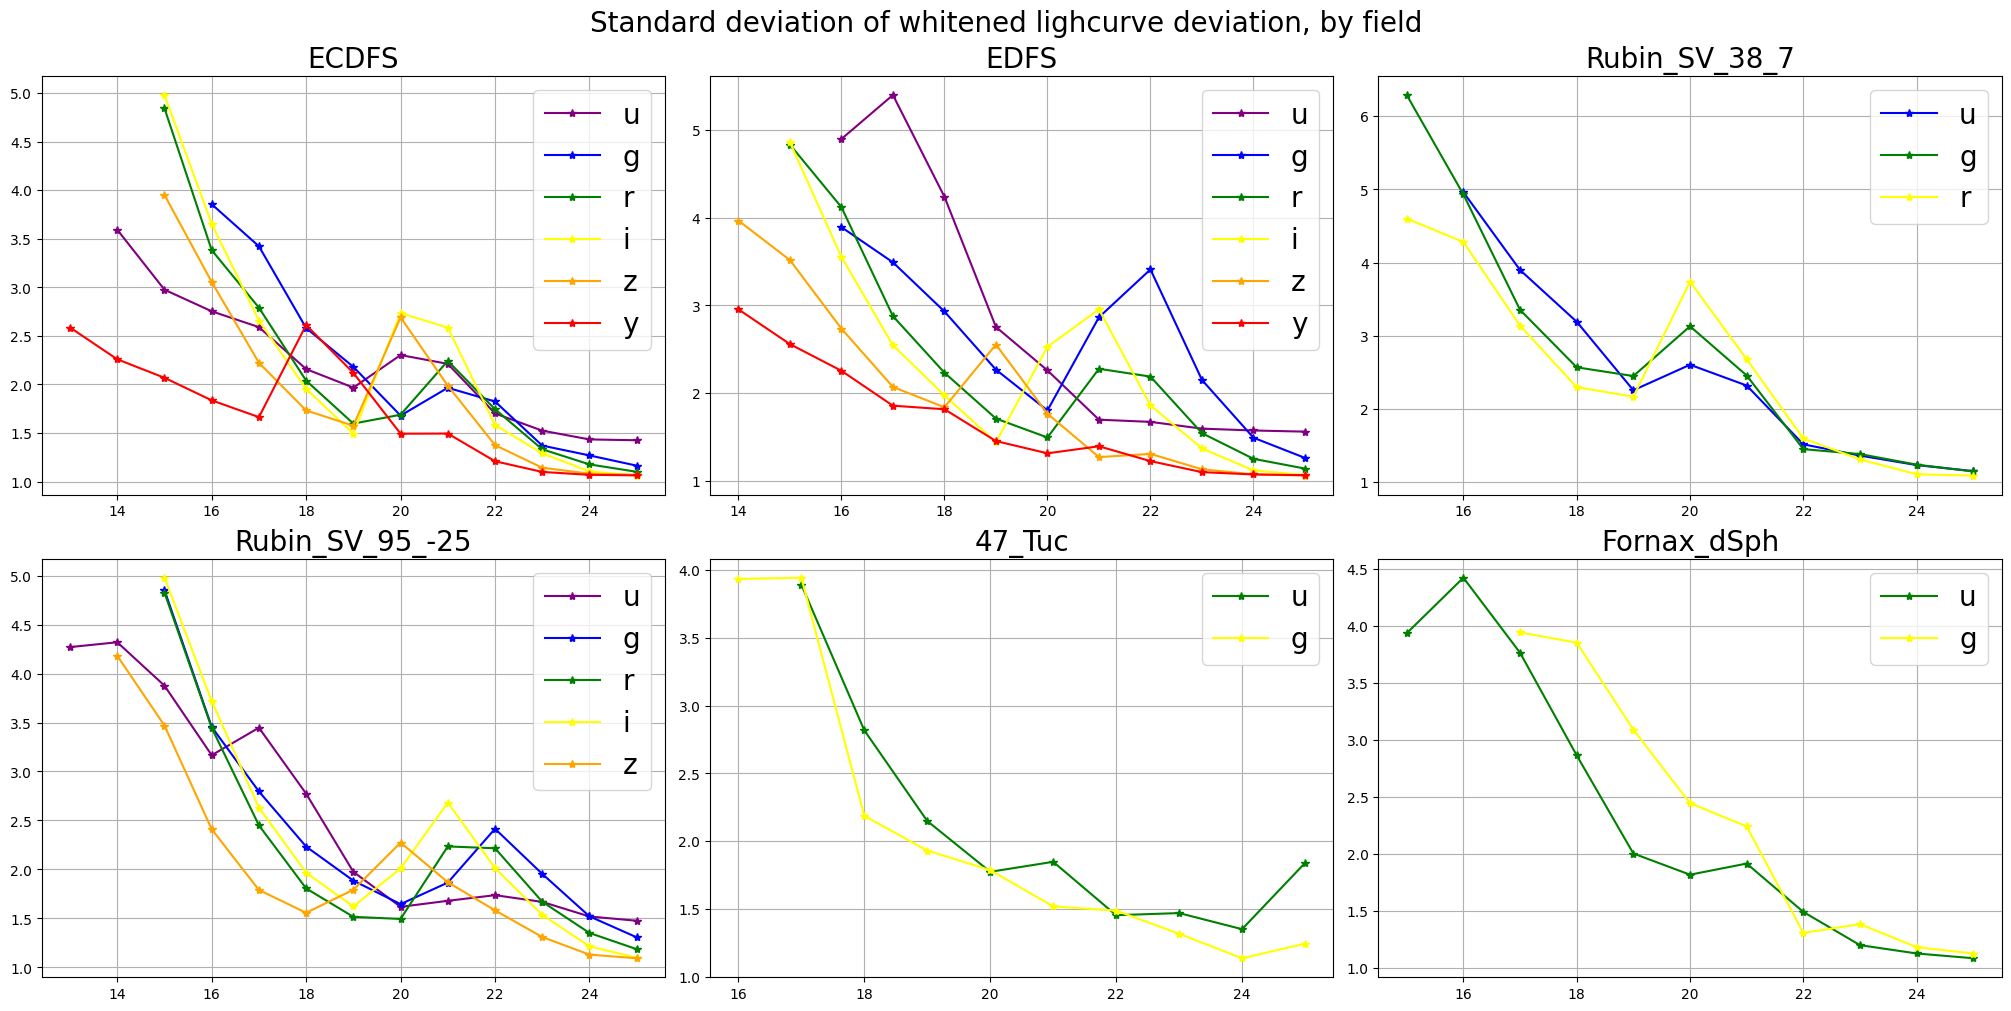

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10), layout="constrained")

for ax, field_name in zip(axs.flat, by_field.keys()):
    display_sums = by_field[field_name]
    
    for band_sums, color in zip(display_sums, colors):
        if len(band_sums) > 0:
            band_sums = band_sums.query("mag_bin <= 25")
            std_devs = np.sqrt(band_sums["sum_sq"]/band_sums["count"])
            ax.plot(band_sums["mag_bin"], std_devs, color=color, marker="*")
    
    ax.legend(bands, fontsize=20)
    
    # ax.xlabel("magnitude bin")
    # ax.ylabel("whitened std dev")
    ax.set_title(field_name, fontsize=20)
    ax.grid()
    # ax.ylim(0, 7)

fig.suptitle("Standard deviation of whitened lighcurve deviation, by field", fontsize=20)


In [ ]:
all_sums[0][0]

In [ ]:
result.groupby("mag_bin", dropna=False).sum()